In [1]:
import torch
import torch.nn as nn

import os
import logging
from collections import deque

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm
from pathlib import Path

/var/folders/ny/1xf5rf9x4_d3m3g_2v65v8200000gn/T/ipykernel_49682/534817211.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

In [3]:
SEED = 12312408192
NUM_STEPS = 100000
BATCH_SIZE = 100
M = 32
N = 32
C = 2000
T = 2000
E = 10
EPS = 0.2
GAMMA = 0.99
LAMBDA = 0.95
STEP_SIZE_ACTOR = 3e-4
STEP_SIZE_CRITIC = 1e-3
N_HIDDEN_UNITS_ACTOR = 64
N_HIDDEN_UNITS_CRITIC = 64

MAX_AVG_REWARD = 500.

WINDOW_MEAN = 100
LOG_EVERY_NTH_STEPS = 5000
OUT_DIR = "./checkpoints/ppo"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class PPO:
    def __init__(
        self,
        o_dim,
        a_dim,
        device,
        actor_step_size=0.005,
        actor_n_hidden_units=[16, 32],
        actor_activation_func=nn.ReLU(),
        critic_step_size=0.005,
        critic_n_hidden_units=[16, 32],
        critic_activation_func=nn.ReLU(),
        critic_out_size=1,
        lmbda=1.0,
        gamma=1.0,
    ):
        super().__init__()

        self.device = device
        # Actor
        step_size_actor = actor_step_size
        self.actor_learn = nn.Sequential(
            nn.Linear(o_dim, actor_n_hidden_units[0]),
            actor_activation_func,
            nn.Linear(actor_n_hidden_units[0], actor_n_hidden_units[1]),
            actor_activation_func,
            nn.Linear(actor_n_hidden_units[1], a_dim),
            nn.LogSoftmax(dim=-1),
        ).to(device)

        self.optimizer_actor = torch.optim.Adam(
            self.actor_learn.parameters(), lr=step_size_actor
        )

        # Critic
        step_size_critic = critic_step_size
        self.lmbda = lmbda
        self.gamma = gamma
        self.critic = nn.Sequential(
            nn.Linear(o_dim, critic_n_hidden_units[0]),
            critic_activation_func,
            nn.Linear(critic_n_hidden_units[0], critic_n_hidden_units[1]),
            critic_activation_func,
            nn.Linear(critic_n_hidden_units[1], critic_out_size),
        ).to(device)
        self.optimizer_critic = torch.optim.Adam(
            self.critic.parameters(), lr=step_size_critic
        )

    def learn(self, b, E, N, M, epsilon, batch_size):
        """
        :param b: buffer
        :param E: number of epochs
        :param N: number of total mini-batches
        :param M: number o mini-batches used for learning (<= N)
        :param epsilon: clipping parameter
        :param batch_size: size of mini-batch
        """
        buffer_size = len(b)
        Glmbda = 0.0
        hlmbda = 0.0

        hlmbdas = []
        Glmbdas = []
        vhats = []
        prev_inputs = []
        actions = []
        action_probs = []

        for transition in reversed(b):
            prev_obs, action, reward, curr_obs, d = transition

            # State-features
            prev_input = torch.from_numpy(prev_obs).float().unsqueeze(0).to(self.device)
            curr_input = torch.from_numpy(curr_obs).float().unsqueeze(0).to(self.device)

            # State-values from state-features
            prev_vhat = self.critic(prev_input)
            curr_vhat = self.critic(curr_input)

            # TD error and lambda-advantage estimate
            td_error = reward + (1 - d) * self.gamma * curr_vhat - prev_vhat
            hlmbda = td_error + (1 - d) * self.gamma * self.lmbda * hlmbda

            # lambda-return
            Glmbda = hlmbda + prev_vhat

            # Preferences and log-probabilities
            log_probs = self.actor_learn(prev_input)
            probs = torch.exp(log_probs)
            pol = torch.distributions.Categorical(probs=probs)
            action_prob = pol.log_prob(action).exp()
            action_prob = action_prob.unsqueeze(0)

            hlmbdas.append(hlmbda)
            Glmbdas.append(Glmbda)
            prev_inputs.append(prev_input)
            actions.append(action)
            action_probs.append(action_prob)

        hlmbdas = torch.cat(hlmbdas)
        Glmbdas = torch.cat(Glmbdas)
        prev_inputs = torch.cat(prev_inputs)
        actions = torch.cat(actions).reshape((-1, 1))
        action_probs = torch.cat(action_probs)

        hlmbdas = (hlmbdas - hlmbdas.mean()) / hlmbdas.std()

        for _ in range(E):

            rand_idcs = torch.randperm(buffer_size)

            hlmbdas = hlmbdas[rand_idcs]
            Glmbdas = Glmbdas[rand_idcs]
            prev_inputs = prev_inputs[rand_idcs]
            actions = actions[rand_idcs]
            action_probs = action_probs[rand_idcs]

            for m in range(M):
                start = m * batch_size
                end = m * batch_size + batch_size
                if M == N and m == M - 1 and end < buffer_size:
                    end = buffer_size

                log_probs = self.actor_learn(prev_inputs[start:end])
                probs = torch.exp(log_probs)
                pol = torch.distributions.Categorical(probs=probs)
                a_probs = pol.log_prob(actions[start:end].squeeze()).exp()
                a_probs = a_probs.reshape((-1, 1))

                term1 = hlmbdas.detach()[start:end] * (
                    a_probs / action_probs.detach()[start:end]
                )
                term2 = (
                    torch.clamp(
                        a_probs / action_probs.detach()[start:end],
                        1 - epsilon,
                        1 + epsilon,
                    )
                    * hlmbdas.detach()[start:end]
                )
                zeta = torch.min(term1, term2)
                lossA = -zeta.mean()

                vhats = self.critic(prev_inputs[start:end])
                lossC = (Glmbdas.detach()[start:end] - vhats).pow(2).mean()

                self.optimizer_critic.zero_grad()
                self.optimizer_actor.zero_grad()

                loss = lossA + lossC
                loss.backward()

                self.optimizer_critic.step()
                self.optimizer_actor.step()


In [6]:
def run(
    seed = 0,
    out_dir = "ppo",
    num_steps = 500_000,
    checkpoint = 10_000,
    batch_size = 100,
    M = 32,
    N = 32,
    C = 2000,
    T = 2000,
    E = 10,
    epsilon = 0.2,
    gamma = 0.99,
    lmbda = 0.95,
    actor_step_size = 3e-4,
    n_actor_hidden_units = 64,
    n_critic_hidden_units = 64,
    critic_step_size = 1e-3,
    device="cpu"
):
    """
    :param seed: Random seed
    :param out_dir: Output directory
    :param num_steps: Number of steps to train for.
    :param checkpoint: Number of steps between checkpoints.
    :param batch_size: Batch size.
    :param N: number of total mini-batches
    :param M: Number of batches to learn from during a update burst.
    :param C: Number of samples stored in buffer.
    :param T: Number of steps until net update burst.
    :param E: Number of epochs to train for during a update burst.
    :param epsilon: PPO clipping parameter.
    :param gamma: Discount factor.
    :param lmbda: GAE parameter.
    :param actor_step_size: Actor step size.
    :param n_actor_hidden_units: Number of hidden units in actor.
    :param n_critic_hidden_units: Number of hidden units in critic.
    :param critic_step_size: Critic step size.
    :param device: Device to run the algorithm on.
    """
    torch.manual_seed(seed)

    # Create output directory path for checkpoint
    if not Path(OUT_DIR).exists():
        os.makedirs(OUT_DIR, exist_ok=True)
        print(f"Created output dir: {OUT_DIR}.")
    
    env = gym.make("CartPole-v1")
    env.reset(seed=seed)
    o_dim = env.observation_space.shape[0]
    a_dim = env.action_space.n

    ppo = PPO(
        actor_step_size=actor_step_size,
        actor_n_hidden_units=[n_actor_hidden_units, n_actor_hidden_units],
        actor_activation_func=nn.Tanh(),
        critic_step_size=critic_step_size,
        critic_n_hidden_units=[n_critic_hidden_units, n_critic_hidden_units],
        critic_activation_func=nn.Tanh(),
        gamma=gamma,
        lmbda=lmbda,
        o_dim=o_dim,
        a_dim=a_dim,
        device=device,
    )
    
    G = 0
    ob, _ = env.reset()
    b = deque(maxlen=C)

    N = int(C / batch_size)
    M = N

    scores_deque = deque(maxlen=WINDOW_MEAN)
    scores_avg = []
    scores = []

    for steps in tqdm(range(num_steps), desc="Steps: ", position=0, leave=True):
        
        inputs = torch.from_numpy(ob).float().unsqueeze(0).data.to(device)
        
        # We act with the old parameters until those will be updated as well
        log_probs = ppo.actor_learn(inputs)
        probs = torch.exp(log_probs)
        pol = torch.distributions.Categorical(probs=probs)
        a = pol.sample()

        next_ob, reward, terminated, truncated, _ = env.step(a.item())

        # Learn
        b.append((ob, a, reward, next_ob, terminated))

        # Time to learn
        if (steps + 1) % T == 0:
            ppo.learn(list(b), E, N, M, epsilon, batch_size)
            b.clear()

        ob = next_ob

        G += reward
        if terminated or truncated:
            scores.append(G)
            scores_deque.append(G)
            scores_avg.append(np.mean(scores_deque))
            
            G = 0
            ob, _ = env.reset()

        if (steps + 1) % checkpoint == 0:
            logger.info(f"Steps: {steps}\t{scores_avg[-1]:.5f}")

    # Save model
    torch.save(
        {
            "actor_state_dict": ppo.actor_learn.state_dict(),
            "critic_state_dict": ppo.critic.state_dict(),
            "scores": scores
        },
        os.path.join(f"{out_dir}/checkpoint.pth"),
    )
    return scores, scores_avg

scores, scores_avg = run(
    seed = SEED,
    out_dir = OUT_DIR,
    num_steps = NUM_STEPS,
    checkpoint = LOG_EVERY_NTH_STEPS,
    batch_size = BATCH_SIZE,
    M = M,
    N = N,
    C = C,
    T = T,
    E = E,
    epsilon = EPS,
    gamma = GAMMA,
    lmbda = LAMBDA,
    actor_step_size = STEP_SIZE_ACTOR,
    n_actor_hidden_units = N_HIDDEN_UNITS_ACTOR,
    n_critic_hidden_units = N_HIDDEN_UNITS_CRITIC,
    critic_step_size = STEP_SIZE_CRITIC,
    device=DEVICE
)

Steps:   0%|          | 0/100000 [00:00<?, ?it/s]

2023-12-26 20:43:03 - INFO - Steps: 4999	27.36000
2023-12-26 20:43:12 - INFO - Steps: 9999	61.03000
2023-12-26 20:43:18 - INFO - Steps: 14999	100.88000
2023-12-26 20:43:26 - INFO - Steps: 19999	145.07000
2023-12-26 20:43:32 - INFO - Steps: 24999	191.36000
2023-12-26 20:43:39 - INFO - Steps: 29999	233.75000
2023-12-26 20:43:45 - INFO - Steps: 34999	275.14000
2023-12-26 20:43:53 - INFO - Steps: 39999	318.31000
2023-12-26 20:43:59 - INFO - Steps: 44999	357.39000
2023-12-26 20:44:07 - INFO - Steps: 49999	395.03000
2023-12-26 20:44:13 - INFO - Steps: 54999	428.63000
2023-12-26 20:44:22 - INFO - Steps: 59999	456.66000
2023-12-26 20:44:28 - INFO - Steps: 64999	479.76000
2023-12-26 20:44:37 - INFO - Steps: 69999	489.89000
2023-12-26 20:44:43 - INFO - Steps: 74999	493.72000
2023-12-26 20:44:51 - INFO - Steps: 79999	498.00000
2023-12-26 20:44:57 - INFO - Steps: 84999	500.00000
2023-12-26 20:45:05 - INFO - Steps: 89999	500.00000
2023-12-26 20:45:12 - INFO - Steps: 94999	500.00000
2023-12-26 20:45

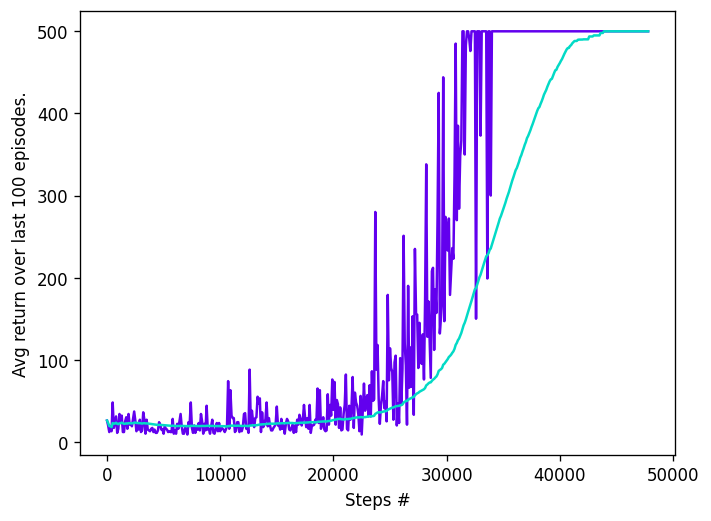

In [10]:
fig = plt.figure(dpi=120)
plt.plot(np.arange(len(scores))*WINDOW_MEAN, scores, c="#6200ee")
plt.plot(np.arange(len(scores))*WINDOW_MEAN, scores_avg, c="#03dac6")
plt.ylabel('Avg return over last 100 episodes.')
plt.xlabel('Steps #')
plt.show()
plt.savefig(f"{OUT_DIR}/avg_return.png")
plt.close()